# Sentiment Analysis Using Word Embedding and CNN

The goal of this project is to build a deep learning model that can classify sentiment into two classes which is positive or negative based on user text review data. the dataset used in this project is IMDB movie review data. Word embedding will be used to extract text reviews into a vector of numbers and CNN will be used as a classifier

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from collections import Counter

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

stopwords = set(nltk.corpus.stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load dataset

In [4]:
dataset = pd.read_csv(r'/content/drive/MyDrive/Datasets/IMDB Movie Review/IMDB Dataset.csv')

In [4]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Data distribution by sentiment

In [5]:
pd.DataFrame(dataset.groupby(['sentiment']).size().sort_values(ascending=False), columns=['total sentiment'])

,total sentiment
sentiment,
positive,25000
negative,25000


In [ ]:
review_len = np.array([len(nltk.tokenize.word_tokenize(review)) for review in dataset['review']])

In [ ]:
print('max length: ', review_len.max())
print('min length: ', review_len.min())
print('mean length: ', review_len.mean())

max length:  2909
min length:  8
mean length:  279.13746


# Data preprocessing

* remove html tag
* remove numbers
* convert to lowercase
* tokenizing
* remove punctuation
* remove stopwords

In [32]:
def text_preprocessing(text):
    # full text level
    # remove html tags
    no_html_text = re.sub(r'<.*?>', '', text)
    # remove numbers
    no_num_text = re.sub(r'\d+', '', no_html_text)
    # lower case conversion
    lowercase_text = no_num_text.lower()

    # word level
    # tokenization
    tokens = nltk.tokenize.word_tokenize(lowercase_text)
    # remove stopwords
    no_stopwords_text = [word for word in tokens if not word in stopwords]
    # remove puncts
    puncts = str.maketrans('', '', string.punctuation)
    no_punct_text = [word.translate(puncts) for word in no_stopwords_text]
    # all alphabet
    alphabet_word = [word for word in no_punct_text if word.isalpha()]
    
    return alphabet_word

apply preprocessing to text review

In [37]:
X = [text_preprocessing(review) for review in dataset['review']]

text review after preprocessed

In [38]:
print(X[1])

['wonderful', 'little', 'production', 'filming', 'technique', 'unassuming', 'oldtimebbc', 'fashion', 'gives', 'comforting', 'sometimes', 'discomforting', 'sense', 'realism', 'entire', 'piece', 'actors', 'extremely', 'well', 'chosen', 'michael', 'sheen', 'got', 'polari', 'voices', 'pat', 'truly', 'see', 'seamless', 'editing', 'guided', 'references', 'williams', 'diary', 'entries', 'well', 'worth', 'watching', 'terrificly', 'written', 'performed', 'piece', 'masterful', 'production', 'one', 'great', 'master', 's', 'comedy', 'life', 'realism', 'really', 'comes', 'home', 'little', 'things', 'fantasy', 'guard', 'rather', 'use', 'traditional', 'dream', 'techniques', 'remains', 'solid', 'disappears', 'plays', 'knowledge', 'senses', 'particularly', 'scenes', 'concerning', 'orton', 'halliwell', 'sets', 'particularly', 'flat', 'halliwell', 's', 'murals', 'decorating', 'every', 'surface', 'terribly', 'well', 'done']


# Feature extraction

we need to calculate frequency of each word in the reviews text data

In [45]:
vocabs = Counter()

In [47]:
for tokens in X:
    vocabs.update(tokens)

In [49]:
len(vocabs)

180757

top n words

In [54]:
vocabs.most_common(10)

[('s', 123245),
 ('movie', 85182),
 ('film', 77036),
 ('nt', 66250),
 ('one', 51323),
 ('like', 39061),
 ('good', 28737),
 ('would', 26462),
 ('even', 24533),
 ('time', 23553)]

filter token which has occurence under 2

In [55]:
min_occurence = 2
tokens = [k for k,c in vocabs.items() if c >= min_occurence]

In [56]:
len(tokens)

74985

In [65]:
tokenizer = keras.preprocessing.text.Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokens)

In [67]:
len(tokenizer.word_index)

74986

create a sequence of text review based on their words index

In [71]:
sequences = tokenizer.texts_to_sequences(X)

In [77]:
print('sequence 1 : ', len(sequences[0]))
print('sequence 2 : ', len(sequences[1]))
print('sequence 3 : ', len(sequences[2]))
print('sequence 4 : ', len(sequences[3]))

sequence 1 :  171
sequence 2 :  86
sequence 3 :  86
sequence 4 :  66


In [83]:
max_len = max([len(sequence) for sequence in sequences])
print(max_len)

1442


every sequence has different length, we can add padding at the last index so every sequence will be in the same length. the sequences which have length bigger than maxlen will be truncated

In [84]:
padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences, padding='post', truncating='post', maxlen=1000)

every sequence in the same length

In [85]:
print('sequence 1 : ', len(padded_sequences[0]))
print('sequence 2 : ', len(padded_sequences[1]))
print('sequence 3 : ', len(padded_sequences[2]))
print('sequence 4 : ', len(padded_sequences[3]))

sequence 1 :  1000
sequence 2 :  1000
sequence 3 :  1000
sequence 4 :  1000


# Train test split

In [86]:
labels = []

for label in dataset['sentiment']:
    if label == 'positive':
        labels.append(1)
    else:
        labels.append(0)

labels = np.array(labels)

In [87]:
labels[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [90]:
labels.shape

(50000,)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

# Neural network model

word embedding initialization

In [111]:
vocab_size = len(tokenizer.word_index)+1 # maximum vocabulary (estimation)
embedding_dim = 100 # word vector dimension
max_len = 1000 # maximum sequence length

In [113]:
model = keras.models.Sequential([
        keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(units=50, activation='relu'),
        keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 100)         7498700   
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 32)           16032     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 498, 32)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 15936)             0         
                                                                 
 dense_12 (Dense)            (None, 50)                796850    
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                      

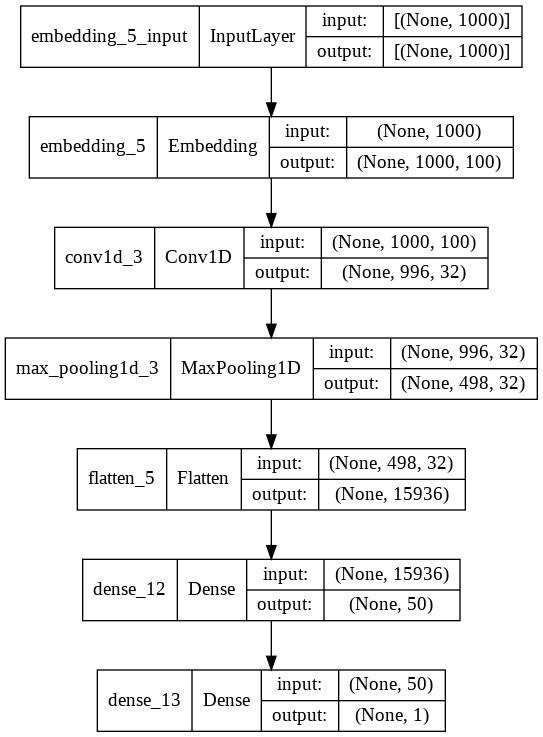

In [116]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [117]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 362s 252ms/step - loss: 0.3216 - accuracy: 0.8553 - val_loss: 0.2435 - val_accuracy: 0.9019
Epoch 2/10
1250/1250 [==============================] - 325s 260ms/step - loss: 0.1017 - accuracy: 0.9640 - val_loss: 0.3177 - val_accuracy: 0.8866
Epoch 3/10
1250/1250 [==============================] - 335s 268ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.4941 - val_accuracy: 0.8864
Epoch 4/10
1250/1250 [==============================] - 338s 271ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.7160 - val_accuracy: 0.8813
Epoch 5/10
1250/1250 [==============================] - 331s 265ms/step - loss: 0.0119 - accuracy: 0.9963 - val_loss: 0.6937 - val_accuracy: 0.8794
Epoch 6/10
1250/1250 [==============================] - 327s 262ms/step - loss: 0.0104 - accuracy: 0.9966 - val_loss: 0.6935 - val_accuracy: 0.8824
Epoch 7/10
1250/1250 [==============================] - 332s 265ms/step - loss: 0.0040 - accuracy: 0.9987 - val_

In [118]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 11s 34ms/step - loss: 0.9514 - accuracy: 0.8837


[0.9514206051826477, 0.8837000131607056]

(0.0, 1.0)

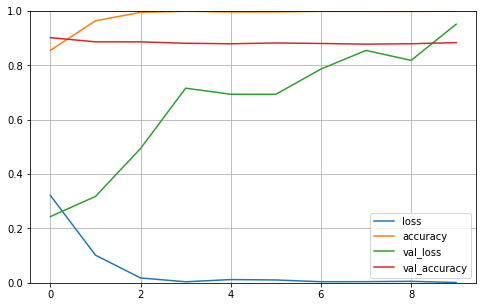

In [119]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

# Predicting data

In [120]:
def predict(text, model):
    predict_text_clean = text_preprocessing(predict_text)
    predict_text_sequence = tokenizer.texts_to_sequences([predict_text_clean])
    predict_text_padded = keras.preprocessing.sequence.pad_sequences(predict_text_sequence, padding='post', truncating='pre', maxlen=1000)

    predicted_proba = model.predict(predict_text_padded)[0][0]

    if round(predicted_proba) == 1:
        return 'positive'
    else:
        return 'negative'

In [121]:
predict_text = "It's 2019 and I still watch this movie sometimes and I am pretty sure that people are gonna keep watching this movie for the next 50 years and while watching this they will still feel that same emotion that they felt when they watched this movie for the first time. This movie still in the top 3 of the list of highest grossing movies of all time even after 22 years."

predict(predict_text, model)

'positive'

# Save the model

In [123]:
model.save(r'/content/drive/MyDrive/model/cnn-embedding-sentiment-analysis.h5')